In [1]:
import numpy as np
from scipy import linalg, io, sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gurobipy as gp
from gurobipy import GRB

# Linear Programs:

We consider Linear programs in the form:

$
\mathrm{min}\, g^\top x \\
\mathrm{st.}\, A^\top x = b, \\
\quad l \leq x \leq u.
$ 

## Part 1

<u>Lagrangian of the problem</u>:

The lagrangian is

$\mathcal{L}(x,\lambda)=g^\top x - \lambda^\top(A^\top x - b) - s x + \mu x????$

## Part 2

<u>Necessary and sufficient optimality conditions</u>:

TODO!!

## Part 3

We wish to transform the following problem into the above form:

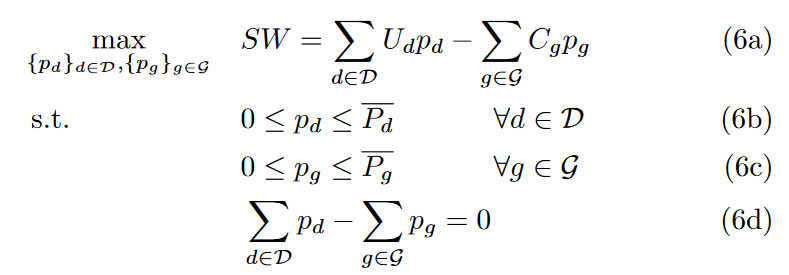

let us denote all $p_d$ as $P_d$ and all $p_g$ as $P_g$. We can finally rewrite the problem as:

$
\mathrm{min}\, \begin{bmatrix} -U \\ C \end{bmatrix}^\top \begin{bmatrix} P_d \\ P_g\end{bmatrix} \\[1 ex]
\mathrm{st.}\, \begin{bmatrix} e \\ -e \end{bmatrix}^\top \begin{bmatrix} P_d \\ P_g\end{bmatrix} = 0, \\[1 ex]
\begin{bmatrix} 0 \\ 0 \end{bmatrix} \leq \begin{bmatrix} P_d \\ P_g\end{bmatrix} \leq \begin{bmatrix} \bar{P_d} \\ \bar{P_g} \end{bmatrix}.
$

Thus we have:

$
x = \begin{bmatrix} P_d \\ P_g\end{bmatrix},\quad g = \begin{bmatrix} -U \\ C \end{bmatrix},\quad A = \begin{bmatrix} e \\ -e \end{bmatrix},\quad b = 0,\quad l = \begin{bmatrix} 0 \\ 0 \end{bmatrix},\quad u = \begin{bmatrix} \bar{P_d} \\ \bar{P_g} \end{bmatrix}
$

In [2]:
#Loading the test data and casting to common datatype 
#as well as flattening the arrays to be in standard form for numpy
data = io.loadmat("LP_Test.mat")
C = data["C"].astype(np.int32).ravel()
U = data["U"].astype(np.int32).ravel()
Pd_max = data["Pd_max"].astype(np.int32).ravel()
Pg_max = data["Pg_max"].astype(np.int32).ravel()

c_len = len(C)
u_len = len(U)
n = c_len + u_len

lb = np.zeros(n)
ub = np.concatenate((Pd_max,Pg_max))

g = np.concatenate((-U,C))
print(f"g:\n{g}")

g:
[-58 -33 -58 -43 -42 -13 -59   0 -15 -26 -47 -12 -52 -59 -10 -36  -1 -23
  -3 -57 -26 -57 -47 -52 -10  -4 -36 -10 -44 -25  16  28  16   3   5  16
  16  19  12  19  12  19  23   5  11]


In [4]:
model1 = gp.Model("lp1")

#add variables to model with upper and lower bounds
Pd_test = model1.addMVar(shape=u_len, vtype=GRB.CONTINUOUS,name="Pd",
                       lb=np.zeros(u_len), ub=Pd_max)
Pg_test = model1.addMVar(shape=c_len, vtype=GRB.CONTINUOUS,name="Pg",
                       lb=np.zeros(c_len), ub=Pg_max)

#add constraints to model
c_test = model1.addConstr(Pd_test.sum() - Pg_test.sum() == 0, name="eq constraints")

#set the objective function of the model
model1.setObjective((C @ Pg_test - U @ Pd_test), GRB.MINIMIZE)

model1.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5900HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 45 columns and 45 nonzeros
Model fingerprint: 0x3fbac540
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+01]
  Bounds range     [5e+01, 1e+03]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 19 columns
Presolve time: 0.01s
Presolved: 1 rows, 26 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1731700e+05   8.227500e+02   0.000000e+00      0s
       1   -1.5030400e+05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.503040000e+05


In [5]:
sol_gurobi_init = np.array(model1.x)
print(f"[Pd Pg] = \n{sol_gurobi_init}")


[Pd Pg] = 
[225. 234. 213. 228. 231.   0. 218.   0.   0. 225. 209.   0. 222. 242.
   0. 245.   0. 217.   0. 242. 243. 230. 204. 230.   0.   0. 245.   0.
 230. 203. 420.   0. 560. 310. 460.  45. 151.   0. 420.   0. 785.   0.
   0. 410. 975.]
market clearing price: 150304.0


## Part 4

<u>Primal-dual interior-point algorithm theory</u>:

TODO!

## Part 5

<u>Primal-dual interior-point algorithm implementation</u>:

In [62]:
def lp_ip_init(g, A, b, u):
    '''
    lp form:
        min g'x
        st A'x=b
           x+t=u
            x>=0
    '''
    n, m  = A.shape
    #we know x=0 is feasible:
    x0 = u / 2

    #therefore t=u is also feasible:
    t0 = u / 2

    l0 = np.ones(m)/m
    y0 = np.ones(n)/n
    z0 = np.ones(n)/2*n

    return x0, l0, y0, z0, t0



In [88]:
def lp_ip(g, A, b, l, u, x0=None, max_iter=100, tol=1e-8, verbose=False):
    '''
    Primal-dual nterior-point predictor-corrector algorithm for linear programs (LPs) of form:
            min g'x
        st. A'x = b
        l <= x <= u
    with lagrangian:
        L(x,l,y,z,t) = g'x - l'(Ax-b) - y'x - 

    Params:
        g: n dimensional vector of objective coefficients
        A: n x m dimensional array of equality constraints
        b: m dimensional vector of rhs of equality constraints
        l: n dimensional vector of lower bound for x
        u: n dimensional vector of upper bound for x
    '''
    n = len(g)
    m = len(b)
    

    print(n)
    print(m)

    #ensure A is of shape n x m incase only 1 equality constraint:
    if len(A.shape) == 1:
        A = A[:,np.newaxis]

    
    #transform bound constraint to be of form 0 <= x <= u_bar:
    #let x_bar = x - l:, then new upper bound = u - l:
    u_bar = u - l
    b_bar = b - A.T @ l

    #declare intital variables
    if x0 is None:
        x0 = np.ones(n) * u_bar / 2 #x variables
        l0 = np.zeros(m)            #lagrange multipliers for eq constraints: l'(A'x-b)
        y0 = np.ones(n)             #
        z0 = np.ones(n)             #
        t0 = np.ones(n)             #slack variable for upper bound constraint: x+t=d
    
    x0, l0, y0, z0, t0 = lp_ip_init(g, A, b_bar, u_bar)

    CONVERGED = False
    iter = 0

    xks = np.zeros((max_iter+2,n))
    lks = np.zeros((max_iter+2,m))
    yks = np.zeros((max_iter+2,n))
    zks = np.zeros((max_iter+2,n))
    tks = np.zeros((max_iter+2,n))

    x = x0
    l = l0
    y = y0
    z = z0
    t = t0

    rL = g - A @ l - y - z  #dual feasibility
    rA = - A.T @ x + b_bar      #primal feasibility
    rUB = x + t - u_bar     #primal feasibility
    rYX = y*x               #nonnegativity on x
    rZT = z*t               #nonnegativity on slack variable t
    mu = (np.dot(x,y) + np.dot(z,t)) / (2 * n)
    
    #stop cond:
    #TODO: subject to change
    rho = max(1, A.max(), g.max(), b_bar.max())
    rL_cond = tol * rho
    rA_cond = tol * rho
    rUB_cond = tol * rho
    mu_cond = tol * 10e-2 * mu

    eta = 0.995

    for iter in range(max_iter+1):
        if verbose:
            print(f"---------------\nITERATION: {iter}\n")
            print("residuals:")
            print(f"rL: {linalg.norm(rL,2)}\nrA: {linalg.norm(rA,2)}\nrUB: {linalg.norm(rUB,2)}\nmu1: {mu}")

        xks[iter] = x
        lks[iter] = l
        yks[iter] = y
        zks[iter] = z
        tks[iter] = t

        #check stopping criteria:
        if linalg.norm(rL,2) <= rL_cond and linalg.norm(rA,2) <= rA_cond and linalg.norm(rUB,2) <= rUB_cond and mu <= mu_cond :
            CONVERGED = True
            break


        D = (y / x - z / t)
        r = - rL - rZT / t - rYX / x + (z / t) * rUB 

        #affine direction:
        ADA =  A.T @ ((1/D)[:,np.newaxis] * A)
        if m > 1:
            cho_fac = linalg.cho_factor(ADA)
            dl_aff = linalg.cho_solve(cho_fac,rA - (A / D[:,np.newaxis]).T @ r)
            
        #if only one equality constraint, 
        else: 
            dl_aff = (rA - ((A / D[:,np.newaxis]).T @ r)) / ADA.squeeze()
        
        dx_aff = (r + A @ dl_aff) / D
        dt_aff = - rUB - dx_aff
        dy_aff = - rYX / x - (y / x) * dx_aff 
        dz_aff = - rZT / t - (z / t) * dt_aff

        alpha_aff = min(1, np.min(-x[dx_aff < 0]/dx_aff[dx_aff < 0], initial=1),
                        np.min(-t[dt_aff < 0]/dt_aff[dt_aff < 0], initial=1))
        beta_aff = min(1, np.min(-z[dz_aff < 0]/dz_aff[dz_aff < 0], initial=1),
                        np.min(-y[dy_aff < 0]/dy_aff[dy_aff < 0],initial=1))

        mu_aff = np.dot(x + alpha_aff * dx_aff, y + beta_aff * dy_aff) + np.dot(t + alpha_aff * dt_aff, z + beta_aff * dz_aff)
        #mu_aff = mu_aff / (2 * n)
        sigma = ((mu_aff / (2 * n)) / mu) ** 2 * (mu_aff / n)
        #sigma = (mu_aff / mu) ** 3

        #affine centering correction direction:
        #rYX_bar = rYX + dx_aff * dy_aff - sigma * mu
        #rZT_bar = rZT + dt_aff * dz_aff - sigma * mu
        rYX_bar = rYX + dx_aff * dy_aff - sigma 
        rZT_bar = rZT + dt_aff * dz_aff - sigma
        r_bar = - rL - rZT_bar / t - rYX_bar / x + rUB / t

        if m > 1:
            cho_fac = linalg.cho_factor(ADA)
            dl = linalg.cho_solve(cho_fac,rA - (A / D[:,np.newaxis]).T @ r_bar)

        #if only one equality constraint, 
        else: 
            dl = (rA - ((A / D[:,np.newaxis]).T @ r_bar)) / ADA.squeeze()

        dx = (r_bar + A @ dl_aff) / D
        dt = - rUB - dx
        dy = - rYX_bar / x - (y / x) * dx
        dz = - rZT_bar / t - (z / t) * dt

        alpha = min(1, np.min(-x[dx < 0]/dx[dx < 0], initial=1),
                        np.min(-t[dt < 0]/dt[dt < 0], initial=1))
        beta = min(1, np.min(-z[dz < 0]/dz[dz < 0], initial=1),
                        np.min(-y[dy < 0]/dy[dy < 0],initial=1))

        #update iteration:
        x += alpha * eta * dx
        l += beta * eta * dl
        y += beta * eta * dy
        z += beta * eta * dz
        t += alpha * eta * dt

        #compute residuals:
        rL = g - A @ l - y - z
        rA = - A.T @ x + b_bar
        rUB = x + t - u_bar
        rYX = y * x
        rZT = z * t 
        mu = (np.dot(x,y) + np.dot(z,t)) / (2 * n)
        #mu1 = np.dot(x,y) / n
        #mu2 = np.dot(z,t) / n 

        if verbose:
            print("----STEPSIZES----")
            print(f"alpha_aff: {alpha_aff}\nbeta_aff: {beta_aff}")
            print(f"alpha: {alpha}\nbeta: {beta}")
            print(f"obj: {g.T @ (x+l)}")
    
    #back transform x
    x = x + l
    xks = xks + l

    #save other vars as 
    vars = {"l": l, "y": y, "z": z, "t": t}
    saved_iters = {"lks": lks, "yks": yks, "zks": zks, "tks": tks}

    obj = g.T @ x
    return x, obj, iter, CONVERGED, vars, saved_iters 

In [89]:
A = np.concatenate((np.ones(len(Pd_max)), -np.ones(len(Pg_max))))[:,np.newaxis]
b = np.array([0])

In [90]:
sol_lp_ip, obj, iter, converged, vars, saved_iters = lp_ip(g, A, b, lb, ub, max_iter=40, verbose=True)

45
1
---------------
ITERATION: 0

residuals:
rL: 325.03498102341064
rA: 29.5
rUB: 0.0
mu1: 1697.8001851851852
----STEPSIZES----
alpha_aff: 0.6229147201588884
beta_aff: 0.38382467816787263
alpha: 0.16419621194076942
beta: 0.36241762823214574
obj: 3495.4581080293065
---------------
ITERATION: 1

residuals:
rL: 191.30692382180538
rA: 466.85795719775473
rUB: 0.0
mu1: 906.4834971444578
----STEPSIZES----
alpha_aff: 0.006993572297262197
beta_aff: 0.0018072073204368141
alpha: 1.2489322062410382e-06
beta: 3.5877729134758607e-07
obj: -8095.15609787143
---------------
ITERATION: 2

residuals:
rL: 192.55713227748322
rA: 225.11659705003035
rUB: 6.961868572213853e-14
mu1: 895.0442350205967
----STEPSIZES----
alpha_aff: 0.022475466482682022
beta_aff: 0.02282083629461249
alpha: 0.0001592592555178139
beta: 0.0005636675723391085
obj: -6336.417819435173
---------------
ITERATION: 3

residuals:
rL: 191.61455627955684
rA: 265.85128045816987
rUB: 6.355287432313019e-14
mu1: 882.9212600011343
----STEPSIZES---

In [87]:
print(sol_lp_ip[:45])

[212.59053829 443.76676283 236.85988789 308.26328088 438.37960189
 340.78491897 213.32974711 340.54292302 318.829809   302.11653618
 414.03278058 342.48947654 225.99375927 453.13992179 330.14483328
 408.91358263 333.45236598 308.10085715 338.44058206 299.76968997
 311.22992771 214.718139   214.2132013  213.68031292 324.98327653
 342.85349635 408.91358263 333.01117207 215.83169865 294.76266898
 379.95510248 212.04238297 441.03798018 518.13872744 667.91378271
 213.19878869 374.84443603 484.55065778 630.0355141  400.72220598
 489.62395894 379.68625691 550.24853943 213.79668155 543.15923536]


## Part 6

<u>Simplex theory</u>:

To apply the simplex, we need to further transform the problem. Due to the lower bound being 0 for all variables, we do not need to add slack variables for the lower bound constraints. We can thus rewrite the problem as the following:

$
\mathrm{min}\, \begin{bmatrix} -U \\ C \\ 0 \\ 0 \end{bmatrix}^\top \begin{bmatrix} P_d \\ P_g \\ s_p \\ s_g \end{bmatrix} \\[1 ex]
\mathrm{st.}\, \begin{bmatrix}  e^\top & -e^\top & 0 & 0 \\ I & 0 & I & 0\\ 0 & I & 0 & I \end{bmatrix} \begin{bmatrix} P_d \\ P_g \\ s_p \\ s_g \end{bmatrix} = \begin{bmatrix} 0 \\ \bar{P_d} \\ \bar{P_g} \end{bmatrix}, \\[1 ex]
\begin{bmatrix} P_d \\ P_g \\ s_p \\ s_g \end{bmatrix} \geq \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}.
$

where $s_p, s_g$ are the slack variables corresponding to the previous upper bound constraints.

let $x=[P_d\,\, P_g]^\top$, $s=[s_p\,\, s_g]^\top$, $g=[-U\,\, C]^\top$, $b=[\bar{P_d}\,\, \bar{P_g}]^\top$ and $c \in \mathbb{R}^n$, where $c_i = \begin{cases} 1 & i \in D\\ -1 & i \in G \end{cases}$. We can then rewrite the problem as follows:

$
\mathrm{min}\, \begin{bmatrix} g \\ 0 \end{bmatrix}^\top \begin{bmatrix} x \\ s \end{bmatrix} \\[1 ex]
\mathrm{st.}\, \begin{bmatrix} c^\top & 0 \\ I & I \end{bmatrix} \begin{bmatrix} x \\ s \end{bmatrix} = \begin{bmatrix} 0 \\ b\end{bmatrix}, \\[1 ex]
\begin{bmatrix} x \\ s \end{bmatrix} \geq \begin{bmatrix} 0 \\ 0 \end{bmatrix}.
$

Due to the nature of the problem, finding an intitial feasible point is trivial:

The only original equality constraint was:

$\underset{d \in D}{\sum}p_d - \underset{g \in G}{\sum}p_g = 0$.

This easily holds if $P_d=0$ and $P_g=0$.

furthermore, we can set the initial slack variable values to be equal to the corresponding upper bound to satisfy new equality constraints. This allows us to analytically find an initial feasible point with ease, skipping phase 1 of the simplex procedure.


## Implementing Simplex Algorithm:

first we need to covert LP into standard form:

In [39]:
def lp_standard_form(g, A, b, l=None, u=None):
    '''
    Transform problem of form:
        min g'x
        st Ax=b
        l<=x<=u
    To form:
        min g'x
        st Ax=b
           x>=0
    '''

    m, n = A.shape
    x_eye = np.eye(n)

    #if no lower or upper bounds:
    if l is None and u is None:
        return np.concatenate((g, -g)), np.hstack((A,-A)), b

    #incase lower or upper bounds not supplied:
    if l is None:
        l = np.full(n, -np.inf)
    if u is None:
        u = np.full(n, np.inf)

    #check for lower bound == upper bound:
    lbequb = l == u
    if np.any(lbequb):
        constr = np.eye(n)[lbequb]
        rhs = l[lbequb]
        A = np.vstack((A, constr))
        b = np.concatenate((b, rhs))
        l = l[~lbequb]
        u = u[~lbequb]

    #check for nonnegativity on x, otherwise x = x^+ - x^-
    if not np.all(l >= 0):
        A = np.hstack((A,-A))
        x_eye = np.hstack((x_eye, -x_eye))

    #indexes to include in new constraints matrix:
    l_idx = np.logical_and(np.isfinite(l), l!=0)
    u_idx = np.isfinite(u)

    if np.any(l_idx):
        print(A.shape)
        print(np.eye(n)[l_idx,l_idx])
        A_new = np.block([[A,              np.zeros((m,n))[:,l_idx],           np.zeros((m,n))[:,u_idx]            ],
                          [x_eye[l_idx], -np.eye(n)[np.ix_(l_idx,l_idx)],      np.zeros((n,n))[np.ix_(l_idx,u_idx)]],
                          [x_eye[u_idx], np.zeros((n,n))[np.ix_(u_idx,l_idx)], np.eye(n)[np.ix_(u_idx,u_idx)]      ]])

        b_new = np.concatenate((b,l[l_idx],u[u_idx]))

        g_new = np.concatenate((g, -g, np.zeros(l_idx.sum() + u_idx.sum())))

    else:
        A_new = np.block([[A,            np.zeros((m,n))[:,u_idx]],
                          [x_eye[u_idx], np.eye(n)[u_idx]        ]])

        b_new = np.concatenate((b,l[l_idx],u[u_idx]))

        g_new = np.concatenate((g, np.zeros(l_idx.sum() + u_idx.sum())))

    return g_new, A_new.squeeze(), b_new

In [15]:
def lp_simplex_phase1_form(A, b):
    '''
    Linear program for phase 1 simplex.
    takes an LP of form:
        min g'x
        st. Ax=b
            x>=0
    
    and converts it to:
        min t
        st. [A  I] [x t]' = b

            [x t]'>= 0
    
    initial feasible points are given by:
    x0 = 0
    t_i = |b_i|
    '''

    m, n = A.shape

    diag = np.sign(b)
    diag[diag == 0] = 1

    A_init = np.hstack((A, np.diag(diag)))

    x0_init = np.concatenate((np.zeros(n), np.abs(b)))
    g_init = np.concatenate((np.zeros(n), np.ones(m)))

    n_nonbasic = A_init.shape[1] - A_init.shape[0]
    idx_list = np.arange(A_init.shape[1])
    Bindex = idx_list[n_nonbasic:]
    Nindex = idx_list[:n_nonbasic]

    return g_init, A_init, b, x0_init, Bindex, Nindex

A_new: (46, 90)
b_new: (46,)
g_new: (90,)


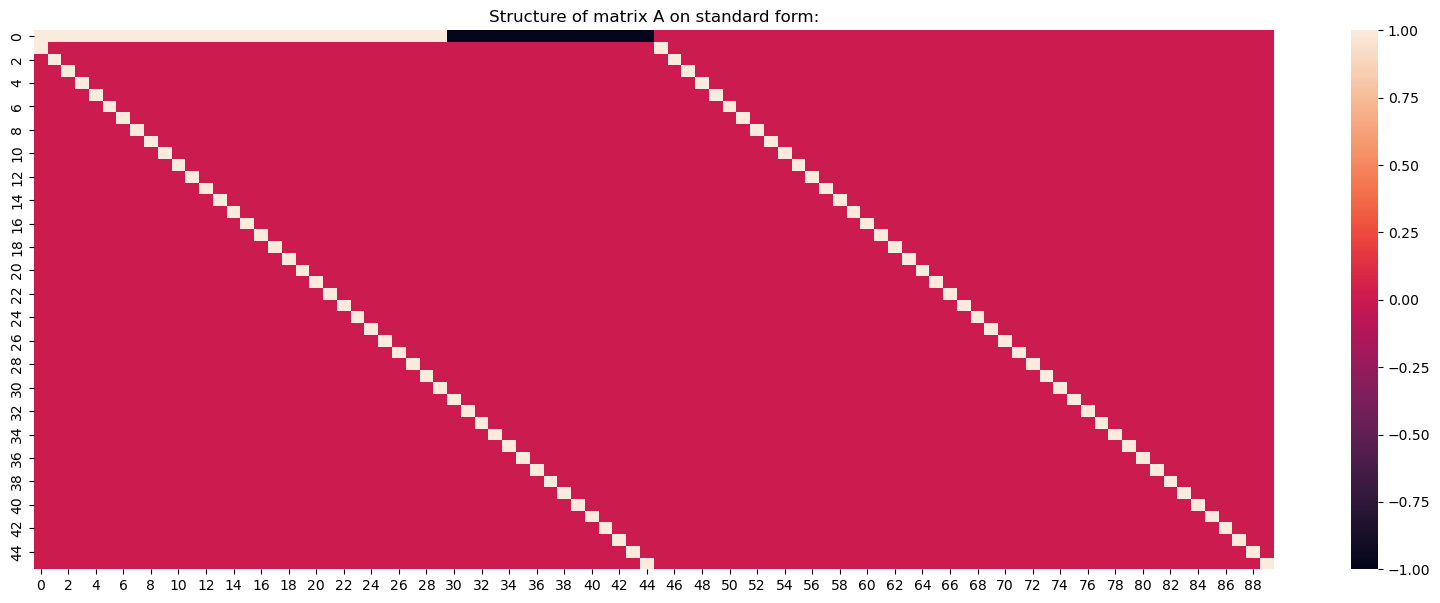

In [40]:
#check phase 1 simplex matrix:
A = np.concatenate((np.ones(len(Pd_max)), -np.ones(len(Pg_max))))[:,np.newaxis]
b = np.array([0])

g_new, A_new, b_new = lp_standard_form(g,A.T,b,lb,ub)
print(f"A_new: {A_new.shape}")
print(f"b_new: {b_new.shape}")
print(f"g_new: {g_new.shape}")

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(A_new, ax=ax)
plt.title("Structure of matrix A on standard form:")
plt.show()

In [17]:
model2 = gp.Model("standard form check")

x2 = model2.addMVar(shape=len(g_new), vtype=GRB.CONTINUOUS, name="x", 
                lb=np.zeros(len(g_new)))

model2.addConstr(A_new @ x2 == b_new, name="eq constraints")

model2.setObjective(g_new.T @ x2, GRB.MINIMIZE)

model2.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5900HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 46 rows, 90 columns and 135 nonzeros
Model fingerprint: 0x84c42c25
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 1e+03]
Presolve removed 45 rows and 64 columns
Presolve time: 0.01s
Presolved: 1 rows, 26 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1731700e+05   8.227500e+02   0.000000e+00      0s
       1   -1.5030400e+05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.503040000e+05


In [18]:
sol_gurobi_standard = np.array(model2.x)[:45]
print(f"[Pd Pg] = \n{sol_gurobi_standard}")
print(f"market clearing price: {-model2.ObjVal}")
print(f"solutions to initial problem and standard form problem are the same: {model2.ObjVal == model1.ObjVal}")

[Pd Pg] = 
[225. 234. 213. 228. 231.   0. 218.   0.   0. 225. 209.   0. 222. 242.
   0. 245.   0. 217.   0. 242. 243. 230. 204. 230.   0.   0. 245.   0.
 230. 203. 420.   0. 560. 310. 460.  45. 151.   0. 420.   0. 785.   0.
   0. 410. 975.]
market clearing price: 150304.0
solutions to initial problem and standard form problem are the same: True


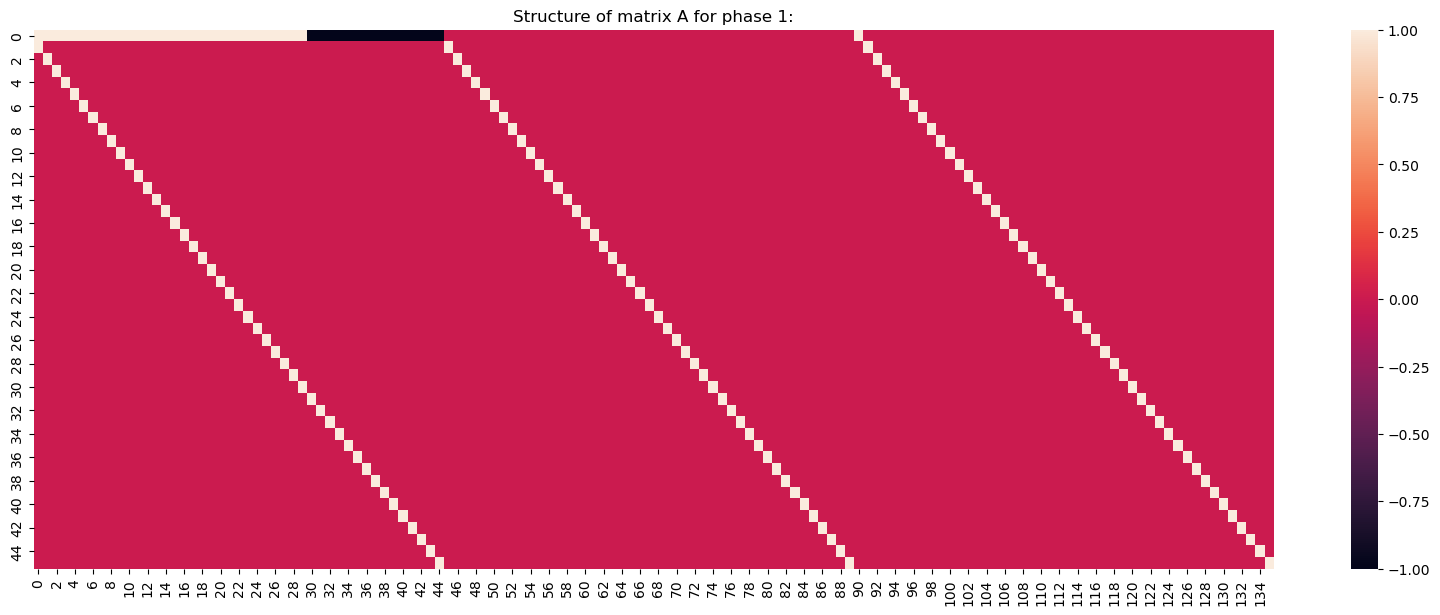

In [20]:
#check LP structure for phase 1:
g_init, A_init, b_init, x0_init, Bindex_init, Nindex_init = lp_simplex_phase1_form(A_new, b_new)

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(A_init, ax=ax)
plt.title("Structure of matrix A for phase 1:")
plt.show()

In [21]:

model3 = gp.Model("phase1 check")

x3 = model3.addMVar(shape=len(g_init), vtype=GRB.CONTINUOUS, name="x", 
                lb=np.zeros(len(g_init)))

model3.addConstr(A_init @ x3 == b_init, name="eq constraints")

model3.setObjective(g_init.T @ x3, GRB.MINIMIZE)

model3.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5900HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 46 rows, 136 columns and 181 nonzeros
Model fingerprint: 0x054f7c5e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 1e+03]
Presolve removed 46 rows and 136 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  0.000000000e+00


In [23]:
print("gurobi solution to phase 1:")
print(np.array(model3.x[:90]))
x0_theory = np.concatenate((np.zeros(45), Pd_max, Pg_max))
print("theoretical solution to phase 1:")
print(x0_theory)
print(f"theoretical = gurobi sol for phase 1: {np.allclose(x0_theory,np.array(model3.x[:90]))}")

gurobi solution to phase 1:
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 225. 234. 213. 228. 231. 245. 218. 232. 210. 225. 209.
 246. 222. 242. 221. 245. 220. 217. 229. 242. 243. 230. 204. 230. 212.
 237. 245. 226. 230. 203. 420.  85. 560. 310. 460.  45. 165. 610. 420.
 430. 785. 385. 695. 410. 975.]
theoretical solution to phase 1:
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 225. 234. 213. 228. 231. 245. 218. 232. 210. 225. 209.
 246. 222. 242. 221. 245. 220. 217. 229. 242. 243. 230. 204. 230. 212.
 237. 245. 226. 230. 203. 420.  85. 560. 310. 460.  45. 165. 610. 420.
 430. 785. 385. 695. 410. 975.]
theoretical = gurobi so

Gurobi solution for phase 1 is different from the theoretical one, however, the objective value is 0, thus the point is still in initial feasible point.

In [109]:
def lp_simplex_alg(g, A, b, x0, Bindex, Nindex, max_iter=100, verbose=False):
    '''
    simplex algorithm on matrix form:
    assumes standard form structure, ie.
            min g'x
        st. Ax = b
            x >= 0
    where g -> R^n, A -> R^mxn, b -> R^m

    also assumes knowledge of basic and nonbasic vars.

    params:
        g:          vector, linear objective coefficients
        A:          Equality constraint coeffs
        b:          Equality constraints rhs

    returns:
        x:          optimal solution
        basic:      basic variables at optimum
        non_basic:  non basic variables at optimum
        iter:       iterations

    '''
    is_sparse = sparse.issparse(A)

    n_basic = A.shape[0]
    n_nonbasic = A.shape[1] - n_basic

    vars = np.zeros(len(g))


    xB = x0[Bindex]
    xN = x0[Nindex]

    STOP = False
    iter = 0
    
    while not STOP and iter < max_iter:
        if verbose: print(f"iteration {iter}.\n")
        B = A[:,Bindex]
        N = A[:,Nindex]

        lu_factor = linalg.lu_factor(B)
        mu = linalg.lu_solve(lu_factor, g[Bindex], trans=1)
        lambdaN = g[Nindex] - N.T @ mu

        if np.all(lambdaN >= 0 - 1e-15):
            vars[Bindex], vars[Nindex] = xB, xN
            print(mu)
            return vars, Bindex, Nindex, iter
        
        s = np.argmin(lambdaN)

        sindx = Nindex[s]

        h = linalg.lu_solve(lu_factor, A[:,sindx]) 

        if np.all(h <= 0):
            print("unbounded solution")
            return
        
        ratios = np.ones(n_basic)*100000
        ratios[h > 0] = xB[h > 0] / h[h > 0]
        j = np.argmin(ratios)

        alpha = xB[j] / h[j]

        xB = xB - alpha * h
        xB[j] = alpha
        xN[s] = 0
        Bindex[j], Nindex[s] = Nindex[s], Bindex[j]
        
        iter += 1

        if verbose:
            print(f"xB: {xB}")       
            print(f"Basic indexes: {Bindex}")
            print(f"entering index s: {s}")
            print(f"most negative lambda: {lambdaN.min()}")
            print(f"leaving index j: {j}")
            print(f"ratio: {ratios.min()}")

    if not STOP:
        print("Max iterations reached, consider increasing max_iter!")
        return

In [110]:
def lp_simplex(gx, Aeq, beq, lb, ub, max_iter=100, verbose=False, run_phase1=False):
    '''
    revised simplex algorithm according to slides provided:
    The program converts linear programs of form
        min g'x
        st. A'x=b
            l<=x<=u
    into:
        min g'x
        st. Ax=b
            x>=0
    
    introducing slack variables where necessary and 
    then solves the LP using the revised simplex method.
    If an initial point is not easily found, perform 
    phase 1 of the simplex algorithm to find initial
    feasible point. Thereafter uses initial feasible 
    point to solve phase 2 of simplex. 

    params:
        gx:         objective coefficients
        Aeq:        equality constraints matrix
        beq:        rhs of equality constraints
        lb:         lower bound on original x
        ub:         upper bound on original x
        max_iter:   (optional) maximum iterations
        verbose:    (optional) if true, print info of problem
                    at each iteration
        run_phase1: (optional) if true then phase1 is forced to run

    returns:
        sol:    returns solution to phase 1 if infeasible,
                else returns solution phase 2.
        iter:   returns num iterations in phase 1 if infeasible,
                else returns num iterations in phase 2.
    '''
    print("Attempting to solve LP using revised simplex algorithm:")
    t1_t = time.perf_counter()
    n_vars, n_constraints = Aeq.shape

    #transpose A:
    Aeq = Aeq.T

    #convert to standard form:
    g, A, b = lp_standard_form(gx, Aeq, beq, lb, ub)

    m, n = A.shape
    n_nonbasic = n - m

    #bypass phase 1 if initial point is easily found
    #by setting slack variables = b:
    bypass = False
    idxlist = np.arange(n) #index list for variables

    #assign slack variables as basic and x variables as nonbasic
    Bindex = idxlist[n_nonbasic:]
    Nindex = idxlist[:n_nonbasic]

    x0 = np.zeros(n)
    x0[Bindex] = b

    #if easy guess of x0 is feasible, then bypass phase1
    if np.all(A @ x0 == b) and not run_phase1:
        bypass = True

    #phase1 of simplex
    if not bypass:
        print("Solving phase 1 simplex:")
        t1_p1 = time.perf_counter()
        g_init, A_init, b_init, x0_init, Bindex_init, Nindex_init = lp_simplex_phase1_form(A, b)
        sol_p1, Bix_p1, Nix_p1, iter_p1 = lp_simplex_alg(g_init, A_init, b_init, 
                                                        x0=x0_init, Bindex=Bindex_init, Nindex=Nindex_init, 
                                                        max_iter=max_iter, verbose=verbose)
        t2_p1 = time.perf_counter()

        obj_p1 = g_init.T @ sol_p1
        print(f"Phase 1 objective: {obj_p1}")
        #if objective value of phase1 is not 0, LP is infeasible
        if not np.allclose(obj_p1, 0):
            print("Infeasible problem.")
            return sol_p1, iter_p1

        #if feasible, use solution for phase1 as intial point in phase2
        Bindex = Bix_p1[Bix_p1 < n]
        Nindex = Nix_p1[Nix_p1 < n]
        x0 = sol_p1[:n]

        print(f"solved phase 1 in {t2_p1-t1_p1}s and {iter_p1} iterations.")

    else:
        print("phase 1 of simplex has been bypassed.")

    if verbose: print(f"initial feasible point:\n{x0}")
    
    #phase2 of simplex
    t1_p2 = time.perf_counter()

    sol_p2, Bix_p2, Nix_p2, iter_p2 = lp_simplex_alg(g, A, b, x0=x0, 
                                                     Bindex=Bindex, Nindex=Nindex, 
                                                     max_iter=max_iter, verbose=verbose)
    t2_p2 = time.perf_counter()

    x = sol_p2[:n_vars]
    t2_t = time.perf_counter()
    print(f"solved phase 2 in {t2_p2-t1_p2}s and {iter_p2} iterations.")
    print("optimal x:")
    print(x)
    print(f"optimal objective: {gx.T @ x}")
    print(f"total run time: {t2_t - t1_t}")


    return x, iter_p2

In [111]:
A = np.concatenate((np.ones(len(Pd_max)), -np.ones(len(Pg_max))))[:,np.newaxis]
b = np.array([0])
ub = np.concatenate((Pd_max,Pg_max))
lb = np.zeros_like(ub)

g = np.concatenate((-U,C))

print("run without bypass:")
sol_simplex1, iters_simplex1 = lp_simplex(g, A, b, lb, ub, max_iter=100, verbose=False, run_phase1=True)

print("\n\nrun with bypass:")
sol_simplex2, iters_simplex2 = lp_simplex(g, A, b, lb, ub, max_iter=100, verbose=False, run_phase1=False)

run without bypass:
Attempting to solve LP using revised simplex algorithm:
Solving phase 1 simplex:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Phase 1 objective: 0.0
solved phase 1 in 0.010048200143501163s and 46 iterations.
[-16. -42. -17. -42. -27. -26.   0. -43.   0.   0. -10. -31.   0. -36.
 -43.   0. -20.   0.  -7.   0. -41. -10. -41. -31. -36.   0.   0. -20.
   0. -28.  -9.   0.   0.   0. -13. -11.   0.   0.   0.  -4.   0.  -4.
   0.   0. -11.  -5.]
solved phase 2 in 0.0023024999536573887s and 16 iterations.
optimal x:
[225. 234. 213. 228. 231.   0. 218.   0.   0. 225. 209.   0. 222. 242.
   0. 245.   0. 217.   0. 242. 243. 230. 204. 230.   0.   0. 245.   0.
 230. 203. 406.   0. 560. 310. 460.  45. 165.   0. 420.   0. 785.   0.
   0. 410. 975.]
optimal objective: -150304.0
total run time: 0.013674600049853325


run with bypass:
Attempting to solve LP using revised simplex algorithm:

### Working version of interior point LP solver

for LPs of form:

$
\mathrm{min}\,\, g^\top x \\
\mathrm{st.}\,\, A x = b, \\
x \geq 0.
$

In [96]:
def lp_ip_init(g, A, b):
    '''
    initial point heuristics for interior point LP of form:
        min g'x
        st. Ax=b
            x>=0
    with lagrangian:
        L(x,y,z) = g'x - y'(Ax-b) - z
    params:
        g:  n dimensional objective coefficients
        A:  m x n dimensional constraints matrix
        b:  n dimensional constraints rhs

    returns:
        x0: initial x
        y0: initial y
        z0: initial z
    '''
    x_bar = A.T @ linalg.inv(A @ A.T) @ b
    y_bar = linalg.inv(A @ A.T) @ A @ g
    z_bar = g - A.T @ y_bar

    x_hat = x_bar + np.max(-1.5*np.min(x_bar),0) 
    z_hat = z_bar + np.max(-1.5*np.min(z_bar),0)

    x0 = x_hat + 0.5 * np.dot(x_hat,z_hat) / np.sum(z_hat)
    z0 = z_hat + 0.5 * np.dot(x_hat,z_hat) / np.sum(x_hat)

    return x0, y_bar, z0

In [105]:
def lp_ip(gx, Aeq, beq, lb, ub, max_iter=1000, tol=1e-8, verbose=False):
    '''
    solve LP of form:
        min g'x
        st. Ax = b
            x >= 0
    Params:
        g:  n dimensional objective coefficients
        A:  m x n dimensional Constraints matrix
        b:  m dimensional constraints rhs
    optional:
        max_iter:   int, max iterations
        tol:        float, stopping criteria tolerance
        verbose:    bool, true prints several parameter values for trouble shooting
    '''

    print("Solving LP using interior-point predictor-corrector method:")
    t1 = time.perf_counter()

    g, A, b = lp_standard_form(gx, Aeq.T, beq, lb, ub)
    print(A.shape)
    m, n = A.shape

    x0, y0, z0 = lp_ip_init(g, A, b)

    xks = np.zeros((max_iter+2,n))
    yks = np.zeros((max_iter+2,m))
    zks = np.zeros((max_iter+2,n))

    x = x0
    y = y0
    z = z0

    #define intitial residuals:
    rL = g - A.T @ y - z #dual feasibility
    rA = - A @ x + b #primal feasibility
    rXZ = x * z #complementary conditions
    s = np.dot(x, z) / n #duality gap

    eta = 0.995

    STOP = False
    iter = 0

    while not STOP and iter < max_iter:
        
        #save iterations to memory
        xks[iter] = x
        yks[iter] = y
        zks[iter] = z

        #cholesky factorize matrix (A Z^-1 X A') 
        mat = (A * (x / z)) @ A.T
        factor = linalg.cho_factor(mat)

        #solve system (AZ^-1XA')dy_aff = rA + A(Z^-1 X rL + Z^-1 rXZ) 
        rA_bar = rA + A @ ( rL * x / z + rXZ / z)
        dy_aff = linalg.cho_solve(factor, rA_bar)

        #back substitute to find dx_aff, dz_aff
        dx_aff = (A.T * (x / z)[:,None]) @ dy_aff - x / z * rL - rXZ / z
        dz_aff = -rXZ / x - z / x * dx_aff

        #calculate max step sizes alpha and beta for primal 
        #and dual spaces according to 14.32 and 14.33 in 
        #Numerical Optimization J. Nocedal, S. J. Wright
        alpha_aff = min(1, np.min(-x[dx_aff < 0]/dx_aff[dx_aff < 0])) 
        beta_aff = min(1, np.min(-z[dz_aff < 0]/dz_aff[dz_aff < 0]))

        #duality gap for affine step
        s_aff = np.dot(x + alpha_aff * dx_aff, z + beta_aff * dz_aff) / n
        #centering parameter
        sigma = (s_aff / s) ** 3

        #solve for rhs of aggregated predictor, corrector and centering contributions
        rXZ_bar =  rXZ + dx_aff * dz_aff - sigma * s * np.ones(n)  
        rA_bar = rA + A @ ( rL * x / z + rXZ_bar / z)
        dy = linalg.cho_solve(factor, rA_bar)

        #back substitute for dx and dy
        dx = (A.T * (x / z)[:,None]) @ dy - x / z * rL - rXZ_bar / z
        dz = -rXZ_bar / x - z / x * dx

        #calculate step sizes 
        alpha = min(1, np.min(-x[dx < 0]/dx[dx < 0])) 
        beta = min(1, np.min(-z[dz < 0]/dz[dz < 0]))

        #update parameters
        x = x + eta * alpha * dx
        y = y + eta * beta * dy
        z = z + eta * beta * dz

        #update residuals
        rL = g - A.T @ y - z
        rA = - A @ x + b
        rXZ = x * z
        s = np.dot(x, z) / n

        if verbose:
            print(f"iter: {iter}:\n")
            print(f"s: {s}")
            print(f"|rL|: {linalg.norm(rL,2)}")
            print(f"|rA|: {linalg.norm(rA,2)}")
            print(f"alpha: {alpha}, beta: {beta}")
            print(f"complementarity: {np.allclose(x*z, 0)}")
            print(f"obj: {g.T @ x}\n")
            
        iter += 1
        
        #check convergence criteria: ||rL|| < tol, ||rA|| < tol, |s| < tol
        if linalg.norm(rL,2) <= tol and linalg.norm(rA,2) <= tol and abs(s) <= tol:
            xks[iter] = x
            yks[iter] = y
            zks[iter] = z
            STOP = True
    
    t2 = time.perf_counter()

    print(f"Optimal x: \n{x[:n]}")
    print(f"Objective value: {g.T @ x[:n]}")
    print(f"Solved in {t2-t1}s and {iter} iterations.")
            
    return x, xks[:iter], yks[:iter], zks[:iter], iter, STOP

In [106]:
sol_ip1, xks, yks, zks, iter, converged = lp_ip(g, A, b, lb, ub, max_iter=20,tol=1e-8, verbose=False)

Solving LP using interior-point predictor-corrector method:
(46, 90)
Optimal x: 
[2.25000000e+02 2.34000000e+02 2.13000000e+02 2.28000000e+02
 2.31000000e+02 8.57035651e-11 2.18000000e+02 2.84167948e-12
 4.84490436e-10 2.25000000e+02 2.09000000e+02 4.67197009e-11
 2.22000000e+02 2.42000000e+02 1.82690734e-11 2.45000000e+02
 3.09870673e-12 2.17000000e+02 4.00282522e-12 2.42000000e+02
 2.43000000e+02 2.30000000e+02 2.04000000e+02 2.30000000e+02
 1.79304360e-11 4.67167297e-12 2.45000000e+02 1.84586485e-11
 2.30000000e+02 2.03000000e+02 4.15498153e+02 1.22003684e-12
 5.54254258e+02 3.10000000e+02 4.60000000e+02 4.35684804e+01
 1.62679108e+02 4.63381163e-10 4.20000000e+02 3.51933576e-10
 7.85000000e+02 3.10642329e-10 2.48577558e-12 4.10000000e+02
 9.75000000e+02 4.62481997e-13 8.72068737e-13 4.60659384e-13
 6.33213340e-13 6.46328090e-13 2.45000000e+02 4.50812746e-13
 2.32000000e+02 2.10000000e+02 1.13918224e-12 5.82519697e-13
 2.46000000e+02 5.28891279e-13 4.54051383e-13 2.21000000e+02
 7.6

In [108]:
print(g.T @ sol[:45])
print(yks[-1,0])

-150303.9999999939
-16.000000001140286
